# Analyzing topics of speeches in the German Bundestag

In this project I analyze the stenographic transcripts of speeches held in the German parliament (Bundestag). My goal was to idenfy main topics discussed during parliamentary sessions and how the time spent discussing these topics changed over time. To this end, I applied a Bayesian topic model ([Latent Dirichlet Allocation - LDA](https://dl.acm.org/doi/10.5555/944919.944937)) to this text corpus. Prep-processing and analysis closely followed the steps outlined in [this](https://github.com/sekhansen/FRA_IESE_seminar_2023/tree/main/notebooks) jupyter notebook but were adapted to meet the specific characteristics of this corpus.

## Get data

The data for this project were stenographic transcripts of parliamentary sessions of the German Bundestag. These transcripts were retrieved in json format via the official web [API](https://www.bundestag.de/services/opendata). For this exercise, I only focused on transcripts for the 20th legislative period which commenced in October of 2021.

In [1]:
#import libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
BT_protocols=list() # collected documents

parameters = {"apikey": "I9FKdCn.hbfefNWCY336dL6x62vfwNKpoN2RZ1gp21", "f.wahlperiode": 20, "f.zuordnung": "BT", "format": "json"} # parameters for API requests

while 1:
    # get document from API (API only allows retrieval of 10 entities at a time)
    response = requests.get("https://search.dip.bundestag.de/api/v1/plenarprotokoll-text", params=parameters)
    BT_protocols.extend(response.json()["documents"])

    # update cursor for next API request
    if "cursor" in parameters:
        if parameters["cursor"] == response.json()["cursor"]:
            break # exit when cursor position does not change (all documents retrieved)
        else:
            parameters["cursor"] = response.json()["cursor"]
    else:
        parameters["cursor"] = response.json()["cursor"]

# convert to pandas dataframe only retaining relevant features
BT_protocols=pd.DataFrame(BT_protocols)

BT_protocols.reindex(columns=["id", "dokumentnummer","datum","text"])
BT_protocols.dropna(subset=['text'], inplace=True)

In [3]:
# save scraped protocols
import pickle

pickle.dump(BT_protocols, open( "BT_protocols.p", "wb"))

## Preprocessing

In [4]:
#import libraries
import unicodedata
import nltk
import string
import re
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skowron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/skowron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Apply lower casing to all documents.

In [5]:
docs = [s.lower() for s in BT_protocols["text"]]
docs[0][0:200]

'plenarprotokoll 20/186\ndeutscher bundestag\nstenografischer bericht\n186.\xa0sitzung\nberlin, freitag, den 13.\xa0september 2024\n\n\ninhalt:\n\nzusätzliche ausschussüberweisung \n\n\n\ntagesordnungspunkt 1 (fortsetzun'

Remove all text before and after the verbatim transcripts of speeches (e.g., agenda items and appendices).

In [6]:
docs = [d[d.find("eröffne"):d.rfind("anlage 1")] for d in docs]
print(docs[0][0:50])
print("\n--------------\n")
print(docs[0][-50:])

eröffnet.
interfraktionell ist vereinbart worden, 

--------------

.24 uhr)




anlagen zum stenografischen bericht




Apply additional cleaning steps.

In [7]:
def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) # convert multiple white spaces to single white space
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE) # remove non-ascii characters preserving German special characters, remove digits, remove punctuation
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE) # remove single characters

    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    return text

# apply function
docs = [clean_text(d) for d in docs]
docs[0][0:200]

'eröffnet interfraktionell ist vereinbart worden den entwurf eines gesetzes zum zweiten it änderungsstaatsvertrag auf drucksache zusätzlich an den ausschuss für digitales zur mitberatung zu überweisen '

Tokenize text creating a list of document terms (i.e., words).

In [8]:
tokens = [word_tokenize(d) for d in docs]
tokens[0][0:20]

['eröffnet',
 'interfraktionell',
 'ist',
 'vereinbart',
 'worden',
 'den',
 'entwurf',
 'eines',
 'gesetzes',
 'zum',
 'zweiten',
 'it',
 'änderungsstaatsvertrag',
 'auf',
 'drucksache',
 'zusätzlich',
 'an',
 'den',
 'ausschuss',
 'für']

Remove stopwords (i.e., words with little semantic meaning).

In [9]:
stop_words = set(stopwords.words("german")) # stopwords as specified in the nltk library

def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]

tokens = [remove_stopwords(t, stopwords=stop_words) for t in tokens]
tokens[0][0:20]

['eröffnet',
 'interfraktionell',
 'vereinbart',
 'worden',
 'entwurf',
 'gesetzes',
 'zweiten',
 'it',
 'änderungsstaatsvertrag',
 'drucksache',
 'zusätzlich',
 'ausschuss',
 'digitales',
 'mitberatung',
 'überweisen',
 'sehe',
 'widerspruch',
 'beschlossen',
 'setzen',
 'haushaltsberatungen']

Lemmatize words using the spacy library with a trained pipeline for German language (de_core_news_sm). This step replaces words by their dictonary form, which unified terms with similar semantic meaning.

In [10]:
# lemmatize with standard spaCy lemmatizer (takes some time)
!python -m spacy download de_core_news_sm

import spacy

nlp_standard = spacy.load('de_core_news_sm')
def lemmatize_sent(sent):
    sent = ' '.join(sent)
    doc = nlp_standard(sent)
    lemmas = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
    return lemmas

# apply function
lemmas = [lemmatize_sent(t) for t in tokens]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 1.2 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [11]:
lemmas = [[lem.lower() for lem in lem_doc] for lem_doc in lemmas] # lower case tokens (again)
lemmas[0][0:20]

['eröffnen',
 'interfraktionell',
 'vereinbaren',
 'werden',
 'entwurf',
 'gesetzes',
 'zweiter',
 'it',
 'änderungsstaatsvertrag',
 'drucksachen',
 'zusätzlich',
 'ausschuss',
 'digital',
 'mitberatung',
 'überweisen',
 'sehen',
 'widerspruch',
 'beschließen',
 'setzen',
 'haushaltsberatungen']

Finally, the data is transformed to a document-term matrix containing the counts of unique terms in each document. The number of terms is reduced based on the term frequency inverse document frequency measure (tf-idf). Terms which rank low on this measure commonly occur across documents and offer little value in identifying topics in the corpus.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# generate document frequency ranking for all terms in the vocabulary
vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing)
df_matrix = vectorizer.fit_transform(lemmas).toarray()
df_matrix_bool = np.where(df_matrix > 0, 1, 0)
scores_df = df_matrix_bool.sum(axis=0)

sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab_keys = list(np.array(sorted_vocab)[:,0])
sorted_scores_df = sorted(set(scores_df), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_df, list(range(len(sorted_scores_df))))}
rank_tup = sorted(zip(scores_df, sorted_vocab_keys),  key=lambda x: x[0], reverse=True)
df_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
df_ranking[:10]

/Users/skowron/opt/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[(186, '--', 0),
 (186, 'abg', 0),
 (186, 'abgeordneter', 0),
 (186, 'afd', 0),
 (186, 'anlage', 0),
 (186, 'arbeit', 0),
 (186, 'aufgabe', 0),
 (186, 'beginn', 0),
 (186, 'bei', 0),
 (186, 'beifall', 0)]

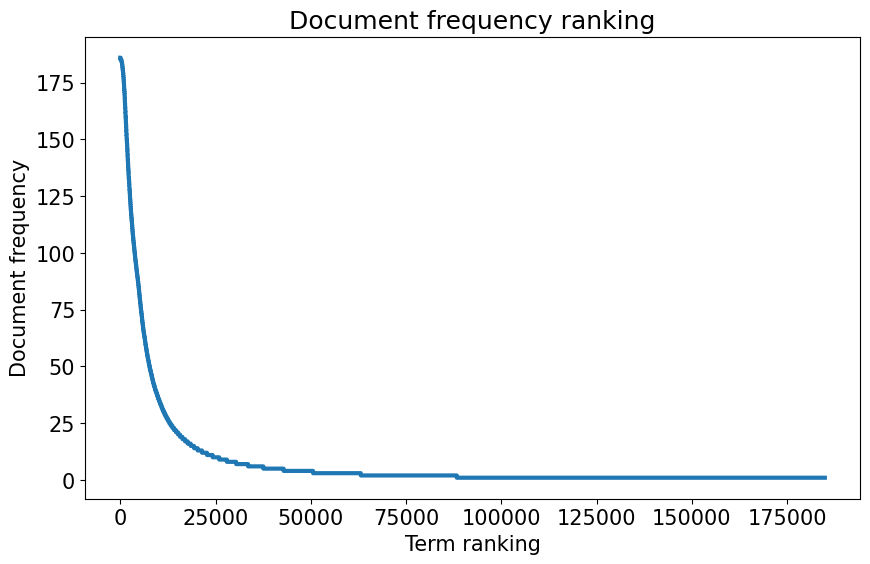

In [13]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15

# plot document frequency
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in df_ranking])
plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()

In [14]:
# function to compute term-frequency inverse document frequency
def tf_idf_compute(term, num_docs, scores_tf, scores_df):
    return (1+np.log(scores_tf[term])*np.log(num_docs/scores_df[term]))

# generate term frequency inverse document frequency ranking for all terms in the vocabulary
sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab = list(np.array(sorted_vocab)[:,0])
scores_tf = df_matrix.sum(axis=0)
scores_tfidf = [tf_idf_compute(t, len(tokens), scores_tf=scores_tf, scores_df=scores_df) for t in range(len(sorted_vocab))]
sorted_scores_tfidf = sorted(set(scores_tfidf), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_tfidf, list(range(len(sorted_scores_tfidf))))}
rank_tup = sorted(zip(scores_tfidf, sorted_vocab),  key=lambda x: x[0], reverse=True)
tfidf_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
tfidf_ranking[:10]

[(24.21617002607205, 'grü', 0),
 (21.592935627362852, 'wi', 1),
 (20.532114575183204, 'n', 2),
 (20.47387893751844, 'ik', 3),
 (20.14484508620526, 'imo', 4),
 (19.66202911824321, 'selbsttötung', 5),
 (19.579348306220982, 'nagoya', 6),
 (19.047270210741143, 'jehovas', 7),
 (18.92746871847764, 'suizidhilfe', 8),
 (18.909405276167167, 'plattdüütsch', 9)]

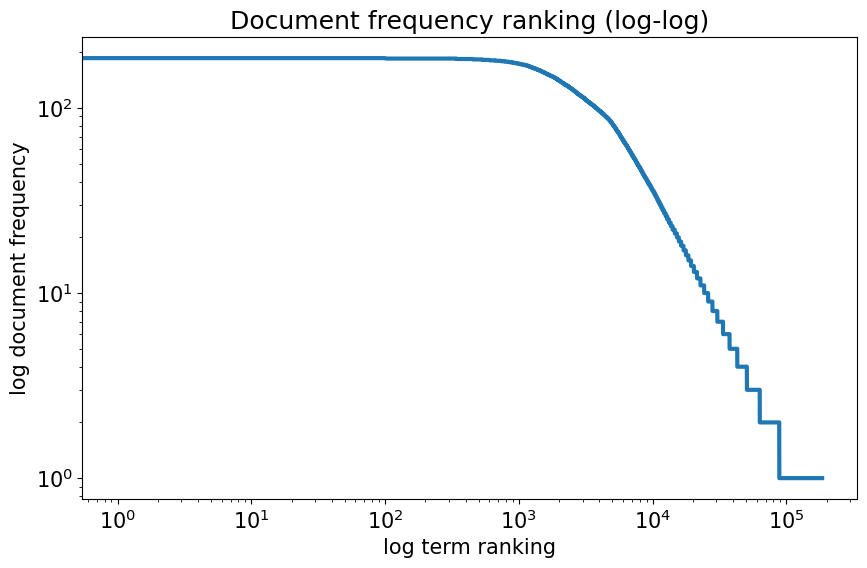

In [15]:
# plot tfidf ranking
plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in df_ranking])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()

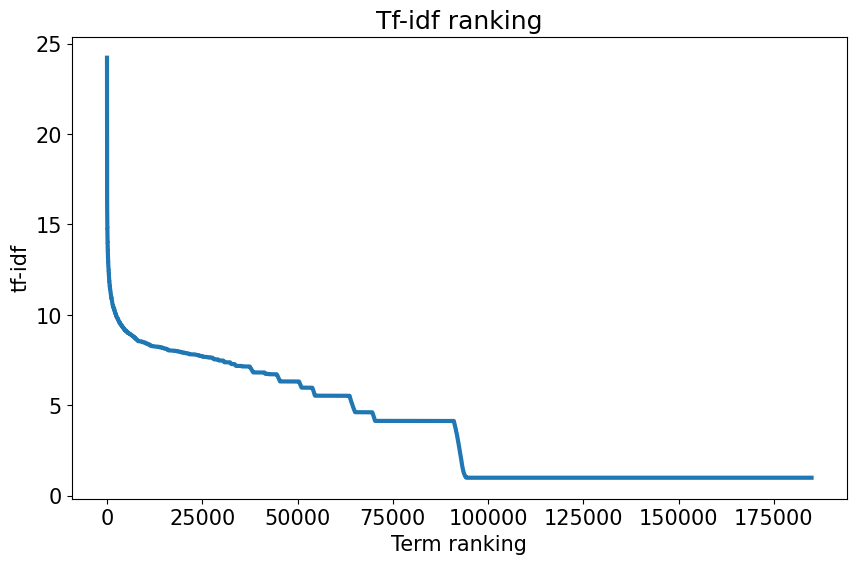

In [16]:
# plot tf-ids ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in tfidf_ranking])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

In [32]:
tfidf_cutoff = tfidf_ranking[52000][0]
tfidf_cutoff

5.979569502789014

In [33]:
(scores_tfidf > tfidf_cutoff).sum()

51004

The above figure shows that terms with a tf-idf lower than that of terms in rank position around 52000 have relatively little value and many terms have similar scores. I therefore remove terms with tf-idf lower than ~5.97. This reduces the number of terms from ~185000 to ~51000.

In [22]:
# auxiliary function to easily remove undesired tokens
def remove(tokens, to_remove):
    if to_remove:
        return [t for t in tokens if t not in to_remove]
    else:
        return tokens

# function to remove tokens in documents according to their df or tfidf score
def rank_remove(ranking, docs, min_cutoff_score=-np.inf, max_cutoff_score=np.inf):

    # define list of tokens to remove
    to_remove_low = set([t[1] for t in ranking if t[0] <= min_cutoff_score])
    to_remove_high = set([t[1] for t in ranking if t[0] > max_cutoff_score])

    # remove tokens
    docs_clean = [remove(d, to_remove_low) for d in docs]
    docs_clean = [remove(d, to_remove_high) for d in docs_clean]

    return docs_clean

# update documents
lemmas_clean = rank_remove(tfidf_ranking, lemmas, min_cutoff_score=tfidf_cutoff)

In [34]:
#create final document-term matrix with selected lemmas
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                   tokenizer=do_nothing,                 # apply no additional tokenization
                                   lowercase=False,                      # convert all characters to lower-case
                                   strip_accents=None,                   # remove non-ascii characters
                                   stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                   ngram_range=(1, 1),                   # generate only unigrams
                                   analyzer='word',                      # analysis at the word-level
                                   max_df=1.0,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=0,                             # ignore tokens that have a lowe document frequency (can be int or percent)
                                   max_features=None,                    # we could impose a maximum number of vocabulary terms
                                   )

# create the document term matrix using lemmas
dt_matrix_lemmas = count_vectorizer.fit_transform(lemmas_clean).toarray()
print(dt_matrix_lemmas.shape)
print(dt_matrix_lemmas.dtype)
word2idx = count_vectorizer.vocabulary_
idx2word = {i:word for word,i in word2idx.items()}


/Users/skowron/opt/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(186, 51004)
int64


> NB: One could think of additonal preprocessing steps such as removing terms specific to this corpus (e.g., speaker names, party names, audience reactions or calls to order) or expanding contractions. However, I omitted these steps for this exercise.

## Fit topic model

I fit a [LDA](https://dl.acm.org/doi/10.5555/944919.944937) model to the document-term matrix in order to identify common topics of speeches across parliamentary sessions. LDA is a Bayesian topic model which assumes that word frequencies within a document are generated from a mixture of probability distributions over topics where each topic is represented by a probability distribution over words. The parameters of the model are the number of topics K, the parameter of the Dirichlet prior distribution over topics for a document (alpha) and the parameter of the Dirichlet prior distribution over words for a topic (epsilon). For simplicity, I chose [recommended prior parameters](https://doi.org/10.1073/pnas.0307752101) rather than finding optimal parameters (e.g., using cross-validation). I set K = 30 which yielded some interpretable topics.

In [36]:
# create LDA object with our parameters
!pip3 install lda
import lda

num_topics = 30
vocab_size = dt_matrix_lemmas.shape[1]
lda_model = lda.LDA(n_topics=num_topics,         # Number of topics
                    alpha=50/num_topics,         # Dirichlet parameter for distribution over topics
                    eta=200/vocab_size,          # Dirichlet parameter for distribution over words
                    n_iter=5000,                 # Number of sampling iterations
                    random_state=92              # The generator used for the initial topics
                    )



# check some paramters
print(lda_model.alpha)
print(lda_model.eta)
print(lda_model.n_topics)

1.6666666666666667
0.003921261077562544
30


In [37]:
# fit model (takes some time)
lda_model.fit(dt_matrix_lemmas)

INFO:lda:n_documents: 186
INFO:lda:vocab_size: 51004
INFO:lda:n_words: 995977
INFO:lda:n_topics: 30
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -15580499
INFO:lda:<10> log likelihood: -11256378
INFO:lda:<20> log likelihood: -10854751
INFO:lda:<30> log likelihood: -10740106
INFO:lda:<40> log likelihood: -10696201
INFO:lda:<50> log likelihood: -10669125
INFO:lda:<60> log likelihood: -10649068
INFO:lda:<70> log likelihood: -10634779
INFO:lda:<80> log likelihood: -10620956
INFO:lda:<90> log likelihood: -10611355
INFO:lda:<100> log likelihood: -10601835
INFO:lda:<110> log likelihood: -10592836
INFO:lda:<120> log likelihood: -10584512
INFO:lda:<130> log likelihood: -10579956
INFO:lda:<140> log likelihood: -10572743
INFO:lda:<150> log likelihood: -10567536
INFO:lda:<160> log likelihood: -10561558
INFO:lda:<170> log likelihood: -10555919
INFO:lda:<180> log likelihood: -10553189
INFO:lda:<190> log likelihood: -10546228
INFO:lda:<200> log likelihood: -10545696
INFO:lda:<210> log likelihoo

Check whether the Gibbs sampler has converged on the model posterior by inspecting the trace of model log likelihoods over sample iterations.

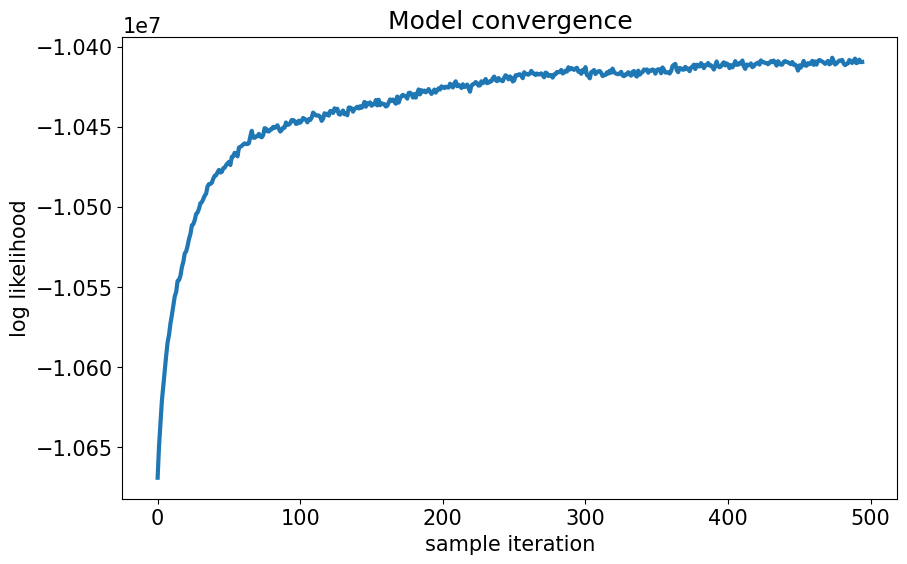

In [38]:
#check model convergence

plt.figure(figsize=(10,6))
plt.plot(lda_model.loglikelihoods_[5:])
plt.title('Model convergence')
plt.ylabel("log likelihood")
plt.xlabel("sample iteration")
plt.show()


The plot shows that the chain successfully converged on the posterior after approximately 300 sample iterations.

> NB: One should also check convergence across multiple chains with different starting points, which I have not done for this exercise.

## LDA results

I inspect the top 15 words for each topic (i.e., with the highest topic probabilities) to get an impression of their interpretability and visualize the results using wordclouds.

In [39]:
topics_dist = lda_model.topic_word_
n_top_words = 15
for i, topic_dist in enumerate(topics_dist):
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    print('Topic {}: {}'.format(i, ' '.join(top_words)))

Topic 0: mali minusma abzug niger sahel malisch sicherheitsstrategie gesenhu nawalny lecht nig sicherheitsrat marshallplan marine
Topic 1: impfpflicht impfung impfen impfstoff virus welle maske omikron infektionsschutzgesetz variante maskenpflicht überlastung nebenwirkung telegram
Topic 2: irregulär asylverfahren barrierefreiheit asylsystem tarifbindung außengrenze aufenthaltsrecht humanität rückführung schutzsuchend asylrecht einreisen mpk innern
Topic 3: kitas wahlrecht frühkindlich startchance religion qualitätsgesetz erzieh bildungssystem grundschule wahlkreise deutschlandticket christ erzieherinn minijob
Topic 4: suizid clankriminalität ärztinn strafgesetzbuch ungeboren assistiert strafrecht erp fiedl abtreibung maritim schwangerschaftsabbrüch selbsttötung suizidprävention
Topic 5: wohn geywitz mieterinn klara wohnungsmarkt car sozialwohnung vermieter bauministerium bauwirtschaft untersuchungsausschuss städtebauförderung bezahlbaren mietrecht
Topic 6: rentenversicherung sgb hartz 

In [40]:
!pip3 install wordcloud
from wordcloud import WordCloud

# define a set of colors for each topic
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
n_top_words = 15
# create a wordcloud object
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_top_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 281.8 kB/s eta 0:00:00a 0:00:01


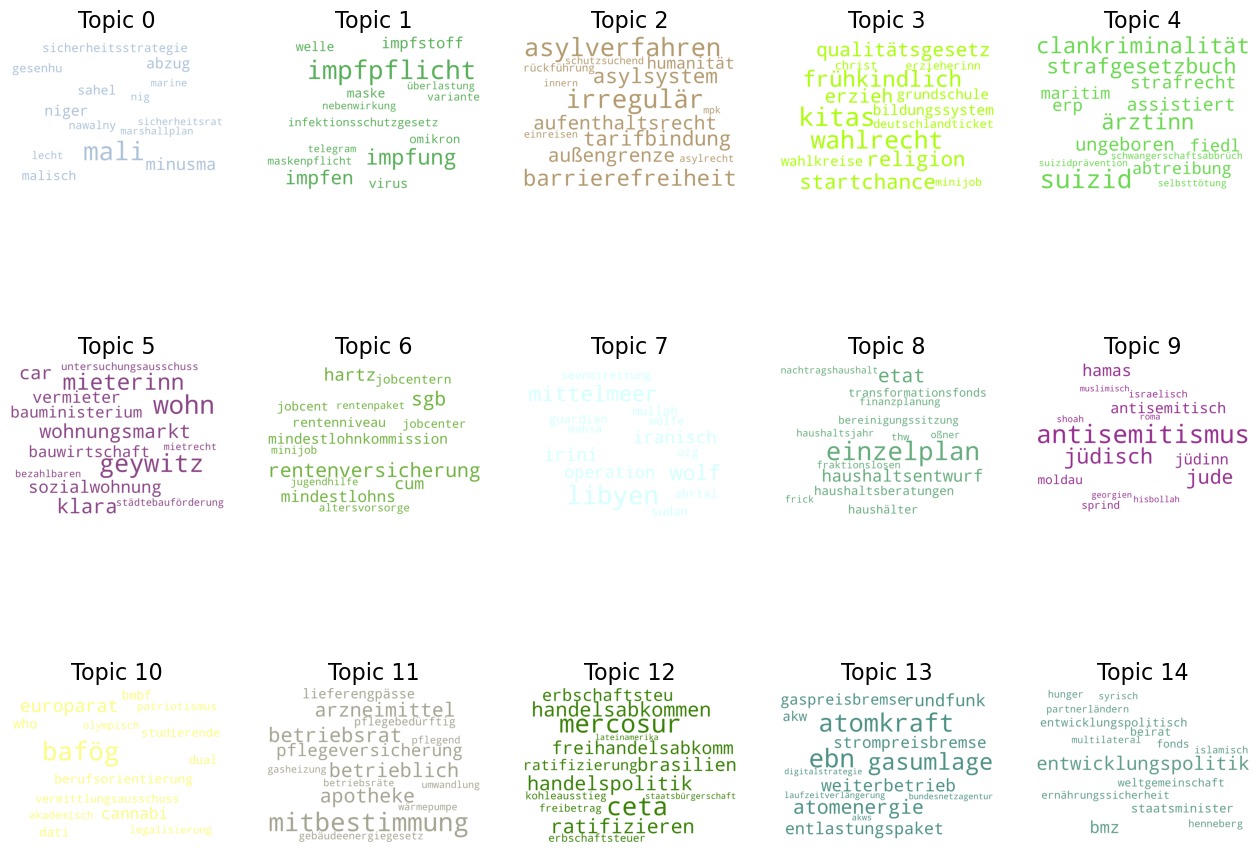

In [41]:
# create figure for the first 15 topics
fig, axes = plt.subplots(3, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):

    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

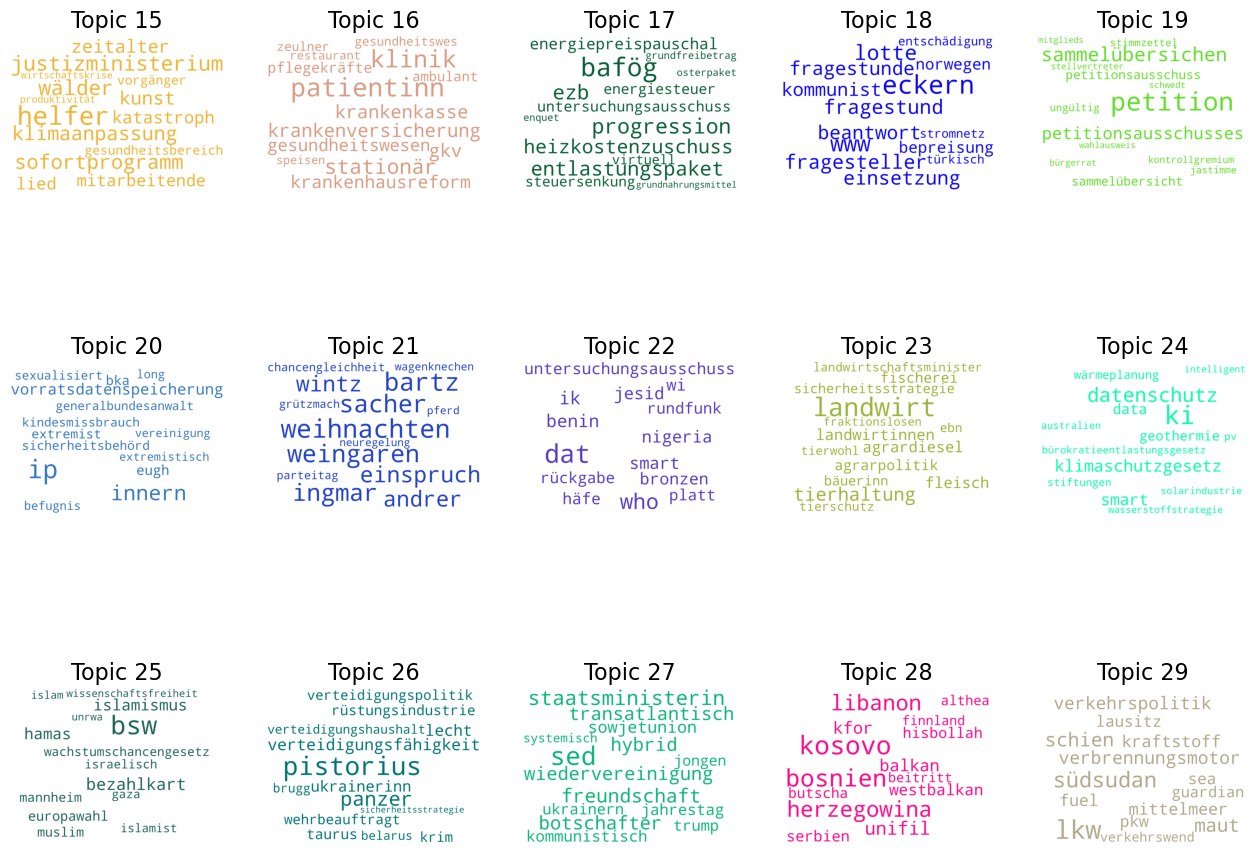

In [42]:
# create figure for the last 15 topics
fig, axes = plt.subplots(3, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten(), 15):

    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

These results show that the LDA model identified some interpretable topics. E.g., topic 1 seems to capture terms associated with the Covid-19 pandemic including terms like compulsory vaccination (Impfpflicht), vaccine (Impfstoff), virus (Virus), mask duty (Maskenpflicht), and Infection Protection Act (Infektionsschutzgesetz). Topic 26 seems to capture foreign affair issues related to the war in Ukraine such as defense capability (Verteidigungsfähigkeit), defense industry (Rüstungsindustrie), panzer (Panzer), and Ukrainian (Ukrainerinn). Topic 13 seems to capture terms related to energy policy including energy crisis (Energiekrise), nuclear power plant (Atomkraftwerk), nuclear power (Atomkraft), and electricity price break (Strompreisbremse).

Finally, I look at how the proportion of time spent discussing some of these interpretable topics changed over the course of the legislative period (as indicated by the frequency of terms belonging to a particular topic encountered in a given session).

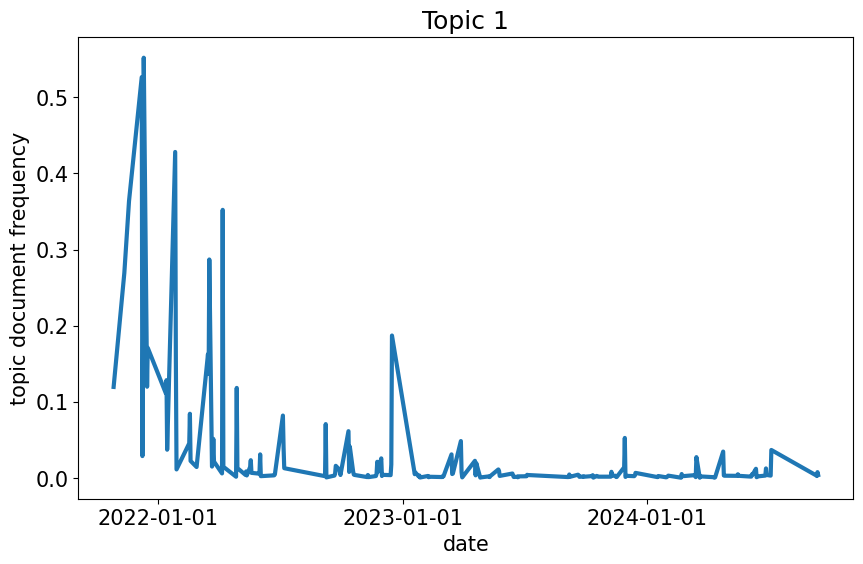

In [45]:
BT_protocols['datum']=pd.to_datetime(BT_protocols['datum'])

tickdates=pd.to_datetime(["2022-01-01", "2023-01-01", "2024-01-01"])

plt.figure(figsize=(10,6))
plt.plot(BT_protocols['datum'],lda_model.doc_topic_[:,1])
plt.xticks(tickdates)
plt.title('Topic 1')
plt.ylabel("topic document frequency")
plt.xlabel("date")

plt.show()

We see that the pandemic topic (topic 6) was a main point of discussion in late 2021/ early 2022 and sharply dropped off in frequency thereafter.

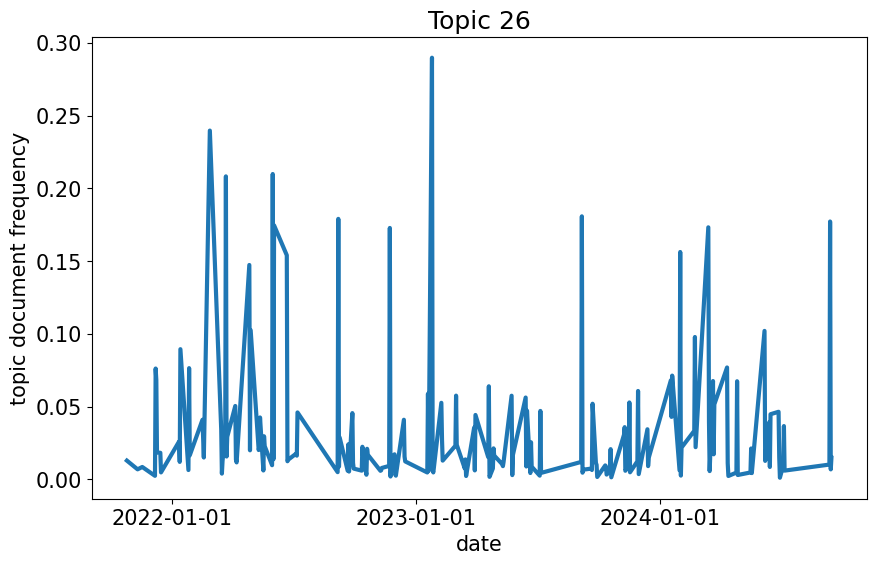

In [46]:
plt.figure(figsize=(10,6))
plt.plot(BT_protocols['datum'],lda_model.doc_topic_[:,26])
plt.xticks(tickdates)
plt.title('Topic 26')
plt.ylabel("topic document frequency")
plt.xlabel("date")

plt.show()

The foreign affairs topic (topic 26) seems to be reoccuring ever since the start of the war in Ukraine in February of 2022.

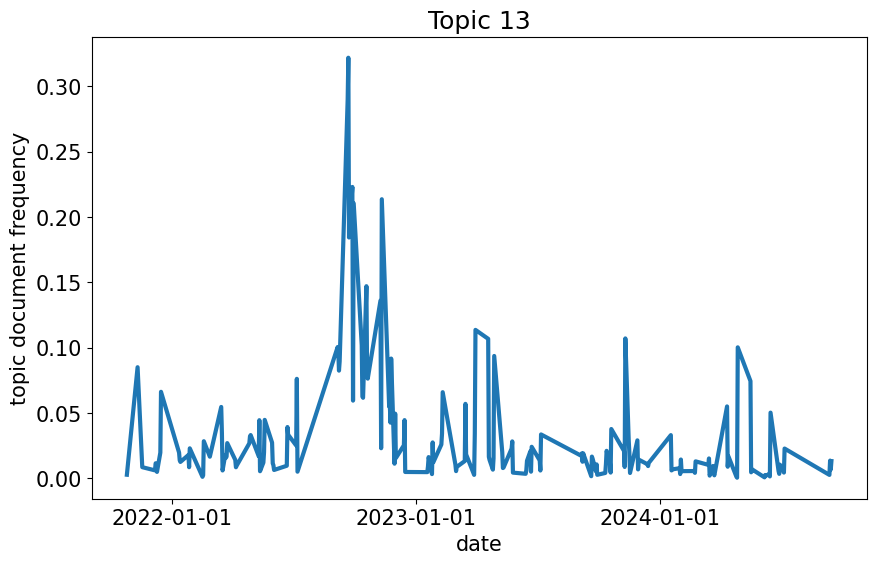

In [50]:
plt.figure(figsize=(10,6))
plt.plot(BT_protocols['datum'],lda_model.doc_topic_[:,13])
plt.xticks(tickdates)
plt.title('Topic 13')
plt.ylabel("topic document frequency")
plt.xlabel("date")

plt.show()

The energy policy topic (topic 13) peaked in late 2022, which seems reasonable given the surge in energy prices partly caused by the war in Ukraine.

Overall, the model successfully identified some interpretable topics with sensible time-courses from this text corpus. Note that these topics were identified from text alone without any available meta-data (e.g., agenda items). These text-derived topics could form the basis for further (machine learning) analyses that go beyond the scope of this exercise.